This notebook is investigating the SNR along a time series;

In [1]:
class masks:
    def __init__(self):
        self.prop = {};
    def Adding(self, name, item):
        self.prop[name] = item;
    def Del(self, name):
        del self.prop[name];

In [2]:
import os;
from google.colab import drive
#drive.mount('/content/drive', force_remount=True);
drive.mount('/content/drive')
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


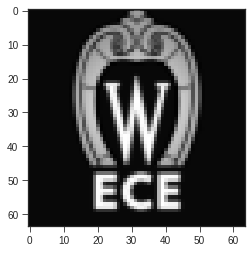

In [4]:
import numpy as np;
import matplotlib.pyplot as plt;
import matplotlib.image as mpimg;
plt.style.use(['seaborn-ticks'])
#plt.style.use(['classic'])

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

r = 64;
c = 64;

#########################################################
ratio_val = 0. ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################

error = [];

pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = False, size = (r,c), anti_aliasing = False);

In [5]:
N_time = 10;
Max_time = 100;

photon_per_sec = 1e6;
#time = np.array([0.01, 0.1] + [(i+1)/(N_time) for i in range(N_time)] ) * Max_time;
time = np.array([(i+1)/(N_time) for i in range(N_time)] ) * Max_time;

Unity = masks();
Residual = masks();
DCT = masks();
Random = masks();

Unity.Adding('basis', np.eye(r*c));
Unity.Adding('inv_basis', np.eye(r*c));
Residual.Adding('basis', np.ones((r*c,r*c)) - Unity.prop['basis']);
Residual.Adding('inv_basis', np.linalg.pinv(Residual.prop['basis']));

pmt.Make_DMD_basis(r*c, scan_mode='Basis', ratio = ratio_val);
DCT.Adding('basis', pmt.DMD_basis);
DCT.Adding('inv_basis', np.linalg.pinv(DCT.prop['basis']));

threshold = 0.5;
Random.Adding('basis', np.ceil(np.random.rand(r*c, r*c) - threshold));
Random.Adding('inv_basis', np.linalg.pinv(Random.prop['basis']));

In [6]:
Unity.Adding('SNR_simu',[]);
Unity.Adding('SNR_theo',[]);
Residual.Adding('SNR_simu',[]);
Residual.Adding('SNR_theo',[]);
DCT.Adding('SNR_simu',[]);
DCT.Adding('SNR_theo',[]);
Random.Adding('SNR_simu',[]);
Random.Adding('SNR_theo',[]);

#N_iter = 10;

In [7]:
Map = {};
Map["Unity"] = Unity;
Map["Residual"] = Residual;
Map["DCT"] = DCT;
Map["Random"] = Random;

|>>>>>·············································| 10.0%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

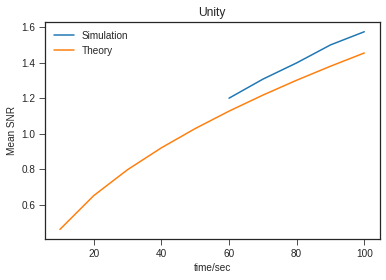

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

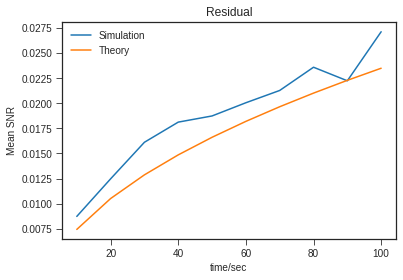

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

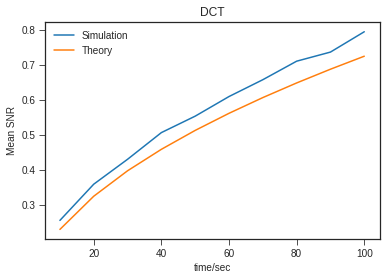

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

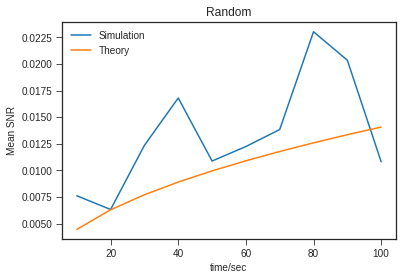

In [8]:
for name in Map:

    Obj = Map[name];

    DMD = Obj.prop['basis'];
    DMD_inv = Obj.prop['inv_basis'];

    Obj.prop['SNR_simu'] = [];
    Obj.prop['SNR_theo'] = [];
    SNR_simu = Obj.prop['SNR_simu'];
    SNR_theo = Obj.prop['SNR_theo'];

    #N_time = 3;
    #time = np.array([(i+1)/(N_time) for i in range(N_time)] ) * Max_time;

    N_iter = 10; ## iteration for 100 times

    for time_index in range(len(time)):
        pmt.YZ_process_bar((time_index+1)/len(time));

        recons_matrix = np.zeros((r*c,N_iter));
        photons = photon_per_sec * time[time_index];
        factor = (r*c)**2;
        light_level = photons / factor;
        #print(light_level);

        pmt.img_tensor = pmt.img_tensor * light_level;

        for i in range(N_iter):
            #pmt.YZ_process_bar((i+1)/N_iter);
            measure = pmt.PMT_measure_simu(1, r*c, Poisson=True, upload_DMD_basis=DMD);
            pmt.PMT_direct_inverse_reconstruction(r,c,DMD_inv, measure, CS=False,display = False);
            recons_matrix[:,i] = pmt.img_reconstructed_vector.reshape((-1,));

        covar = np.cov(recons_matrix);
        #if time_index == 1:
            #break
        #break
        var_simu = np.diag(covar);
        mean_simu = np.mean(recons_matrix, axis = 1);
        SNR_simu.append(mean_simu/var_simu**0.5);
        #break

        ## Theory
        noiseless_measure = pmt.PMT_measure_simu(1, r*c, Poisson=False, upload_DMD_basis=DMD);
        covar_noiseless = (DMD_inv.dot(np.diag(noiseless_measure.reshape((-1,))))).dot(DMD_inv.T);
        SNR_theo.append(pmt.img_tensor[:,:,0].reshape(-1,)/np.diag(covar_noiseless)**0.5);

        pmt.img_tensor = pmt.img_tensor / light_level;


    SNR_simu_mean = [np.mean(i) for i in Obj.prop['SNR_simu']];
    SNR_theo_mean = [np.mean(i) for i in Obj.prop['SNR_theo']];
    plt.figure();
    plt.plot(time, SNR_simu_mean, label = 'Simulation');
    plt.plot(time, SNR_theo_mean, label = 'Theory');
    plt.xlabel("time/sec");
    plt.ylabel("Mean SNR");
    plt.title(name);
    plt.legend();
    plt.show();

In [15]:
print(recons_matrix.mean())

2.1472880171599913


In [16]:
np.version.version

'1.18.5'

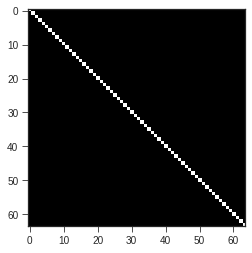

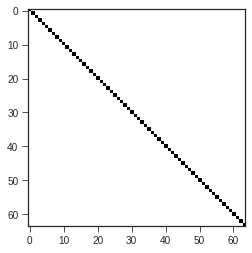

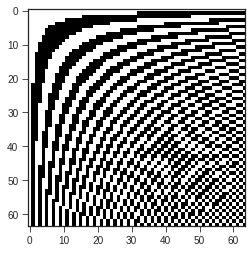

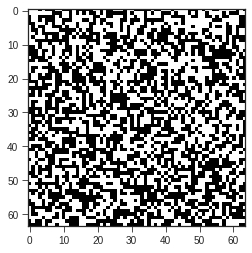

In [9]:
plt.figure();
plt.imshow(Unity.prop["basis"][:64,:64], cmap='gray')
plt.figure();
plt.imshow(Residual.prop["basis"][:64,:64], cmap='gray')
plt.figure();
plt.imshow(DCT.prop["basis"][:64,:64], cmap='gray')
plt.figure();
plt.imshow(Random.prop["basis"][:64,:64], cmap='gray')